In [1]:
import math
import os
import re
import shutil
import sys
import warnings

import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statistics import median

from constants import bins_axis_names, bin_dimensions_regex, boat_speed_feature, \
                    boxplot_axis_name, feature_regex, identifier_features, \
                    fiber_optics_structure_features, fiber_optics_appendix_features, \
                    other_sensor_features, statistics_features, wind_features

In [2]:
def read_csv(fnames):
    """Read CSV file(s) to a Pandas Dataframe"""
    def detect_and_read(fname):
        with open(fname, 'rb') as f:
            return pd.read_csv(fname, sep=';', encoding=chardet.detect(f.read())['encoding'])
    df = pd.concat(map(lambda fname: detect_and_read(fname), fnames), sort=False)
    return df

def preprocess_data(df,
                identifier_cols=identifier_features,
                cols_to_preprocess=fiber_optics_structure_features + fiber_optics_appendix_features,
                other_cols=other_sensor_features + wind_features + [boat_speed_feature],
                regex=feature_regex):
    """Preprocess the dataset"""
    preprocessed_df = pd.DataFrame()
    cols = identifier_cols + cols_to_preprocess + other_cols
    exclude = identifier_cols + other_cols
    for old_col, new_col in cols:
        if (old_col, new_col) in exclude:
            preprocessed_df[new_col] = df[old_col]
        else:
            filter_regex = regex.format(old_col)
            preprocessed_df[new_col] = df.filter(regex=(filter_regex)).mean(axis=1)
    return preprocessed_df

def sort_corr(corr, num_features=20):
    """Sort correlation dictionary"""
    sorted_corr = sorted(corr.items(), key=lambda x: abs(x[1]), reverse=True)[:num_features]
    sorted_corr = sorted(sorted_corr, key=lambda x: x[1], reverse=True)
    return sorted_corr

def compute_sorted_corr(df, target_feature=boat_speed_feature[1], num_features=20):
    """Compute sorted correlated features with the target feature"""
    corr = {}
    for col in df.columns:
        if col != target_feature:
            f_corr = df[target_feature].corr(df[col])
            if not math.isnan(f_corr):
                corr[col] = f_corr
    cols = [target_feature] + [x[0] for x in sort_corr(corr)]
    if len(cols) <= 1:
        return None, None
    return df[cols].corr(), corr

def create_bins(df,
                wind_features=[x[1] for x in wind_features],
                target_feature=boat_speed_feature[1],
                statistics_cols=statistics_features,
                dx=5, dy=2, min_thresh=5,
                exclude=[x[1] for x in identifier_features + wind_features]):
    """Create bins"""
    bins, corr = {}, {}
    for max_x in range(-180, 180, dx):
        for max_y in range(0, math.ceil(df[wind_features[1]].max()), dy):
            query = '{0} >= {2} and {0} < {2}+{4} and {1} >= {3} and {1} < {3}+{5}' \
                        .format(wind_features[0], wind_features[1], max_x, max_y, dx, dy)
            binned_df = df.query(query)
            bin_size = len(binned_df.index)
            bin_corr, unsorted_corr = compute_sorted_corr(binned_df.drop(exclude, axis=1))
            if bin_size >= min_thresh and bin_corr is not None:
                bin_name = 'bin_x{}to{}_y{}to{}'.format(max_x, max_x+dx, max_y, max_y+dy)
                for col, c_corr in unsorted_corr.items():
                    if col in corr:
                        corr[col].append(c_corr)
                    else:
                        corr[col] = [c_corr]
                bins[bin_name] = {'bin': binned_df, 'size': bin_size, 'corr': bin_corr}
    sorted_corr_df = pd.DataFrame(data=sort_corr({col: median(c_corr) for col, c_corr in corr.items()}), columns=statistics_cols)
    return bins, dx, dy, max_x, max_y, sorted_corr_df

def plot_wind_angle_speed(df, x_start, y_start, x_finish, y_finish, dx, dy, markersize,
                        wind_features=[x[1] for x in wind_features],
                        axis_names=bins_axis_names,
                        main=False):
    """Plot the wind angle-speed space"""
    _, ax = plt.subplots()
    ax.set_xlabel(axis_names[0])
    ax.set_ylabel(axis_names[1])
    ax.plot(df[wind_features[0]].tolist(), df[wind_features[1]].tolist(), 'ko', markersize=markersize)
    if main:
        ax.set_xticks(np.arange(x_start, x_finish, dx*6))
        ax.set_xticks(np.arange(x_start, x_finish, dx), minor=True)
        ax.set_yticks(np.arange(y_start, y_finish, dy))
        ax.grid(which='both', lw=.75)
    else:
        ax.set_xlim(x_start, x_finish)
        ax.set_ylim(y_start, y_finish)
        ax.grid(lw=.75)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_boxplot(df,
                target_feature=boat_speed_feature[1],
                axis_name=boxplot_axis_name):
    """Plot the boxplot for boat speed"""
    ax = df.boxplot(column=target_feature,
                    showfliers=df[target_feature].median() == df[target_feature].mode().iloc[0],
                    return_type='axes')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_ylabel(axis_name)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_corr(corr):
    """Plot the correlations with boat speed"""
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, lw=.75)
    plt.xticks(rotation=30, ha='right', fontsize=5)
    plt.yticks(fontsize=5)
    plt.tight_layout()
    plt.show()
    plt.clf()

In [3]:
# Ignore RunTimeWarning.
warnings.filterwarnings('ignore')

# Ignore PyPlot warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# Version number.
version = 'v2'

In [5]:
# Read from CSV file(s).
df = read_csv(map(lambda fname: '20181018datas.csv'.format(version, fname), ['data-part-1', 'data-part-2']))

# Show examples of the data.
df.fillna(0).head()

,Date,Hour,Calib Super Capa_Tension Super Capa 1,Calib Super Capa_Tension Super Capa 2,Calib Temp_Temp Cale Moteur,Calib Temp_Temp Géné,Calib Tension Géné_RPMGene,Calib Tension Géné_tensionGeneCalib,IxBlue_Heading,IxBlue_Heave,...,WTP2_AW_angle,WTP2_AW_speed,WTP2_Orig_TWA,WTP2_Orig_TWS,WTP2_TW_angle,WTP2_TW_dirn,WTP2_TW_speed,solar#0_ibat,solar#1_ibat,Unnamed: 245
0,18/10/2018,06:49:57,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,18/10/2018,06:49:59,0.00000,0.0,0.0,0.0,0.0,0.0,131.19901,0.02447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.06,0.0
2,18/10/2018,06:50:01,0.00000,0.0,0.0,0.0,0.0,0.0,131.20399,0.02461,...,-85.0,6.3,-115.0,7.0,-87.0,45.0,6.3,0.06,0.06,0.0
3,18/10/2018,06:50:02,14.66976,0.0,0.0,0.0,0.0,0.0,131.19901,0.02414,...,-86.0,6.4,-114.0,7.1,-87.0,45.0,6.4,0.06,0.06,0.0
4,18/10/2018,06:50:03,14.66976,0.0,0.0,0.0,0.0,0.0,131.18701,0.02460,...,-86.0,6.4,-124.0,7.6,-87.0,45.0,6.4,0.06,0.06,0.0


In [6]:
# Preprocess the dataset.
df = preprocess_data(df)

# Show examples of the preprocessed data.
df.fillna(0).head()

,Date,Hour,Latitude,Longitude,Max_Front_Beam_Temp_Port,Max_Front_Beam_Temp_To_Port,Max_Front_Beam_To_Port,Max_Front_Beam_Lower_Aft_Rake_Port,Max_Front_Beam_Lower_Forward_Rake_Port,Max_Front_Beam_Upper_Aft_Rake_Port,...,Rudder_Outside_Load_Port,Rudder_Angle_Starboard,Rudder_Elevator_Angle_Starboard,Rudder_Inside_Load_Starboard,Rudder_Outside_Load_Starboard,Shroud_Load_Port,Shroud_Load_Starboard,Wind_Angle,Wind_Speed,Boat_Speed
0,18/10/2018,06:49:57,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,18/10/2018,06:49:59,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,18/10/2018,06:50:01,47.72768,-3.37133,0.0,0.0,0.0,0.0,0.0,0.0,...,6.88853,-1.70606,-0.12130,6.29942,-23.07335,1.93216,1.82482,-81.08372,6.81110,0.17699
3,18/10/2018,06:50:02,47.72768,-3.37133,0.0,0.0,0.0,0.0,0.0,0.0,...,5.78684,-1.70393,-0.11795,7.28973,-23.91546,1.94110,1.84271,-82.25836,6.74398,0.16516
4,18/10/2018,06:50:03,47.72768,-3.37133,0.0,0.0,0.0,0.0,0.0,0.0,...,5.60256,-1.69781,-0.11913,7.08886,-23.86868,1.95005,1.86060,-82.42093,6.70188,0.18394


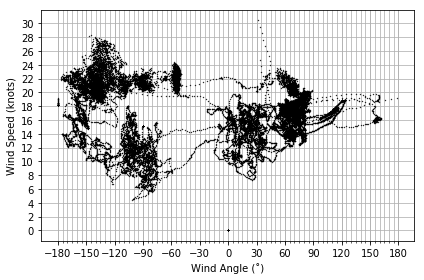

<Figure size 432x288 with 0 Axes>

In [7]:
# Create the bins. Default size: 5˚ by 2 knots.
bins, dx, dy, _, max_y, sorted_corr_df = create_bins(df)

# Plot the bins.
plot_wind_angle_speed(df, -180, 0, 180+1, max_y+1, dx, dy, 0.25, main=True)

In [7]:
# Show the top 20 correlated features.
sorted_corr_df

,Feature,Corr
0,Mainsail_Load,0.358294
1,Righting_Moment,0.315000
2,Max_Board_Deformation_Outside_Port,0.239132
3,Max_Rudder_Starboard_Center,0.229773
4,Max_Rudder_Port_Center,0.184447
5,Max_Board_Deformation_Outside_Starboard,0.180941
6,Shroud_Load_Starboard,0.163148
7,Min_Board_Deformation_Outside_Starboard,0.149790
8,IxB_Pitch,0.106517
9,Min_Rudder_Starboard_Center,0.105214


In [16]:
# Retrieve an example of a bin. (-135 to -130˚, 4 to 6 knots)
bin_name = 'bin_x-125to-120_y14to16'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

KeyError: 'bin_x-125to-120_y14to16'

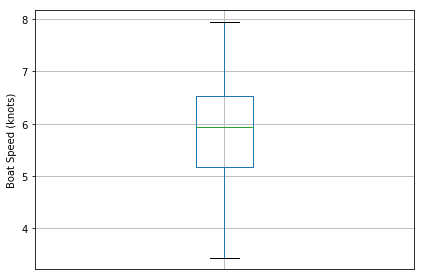

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

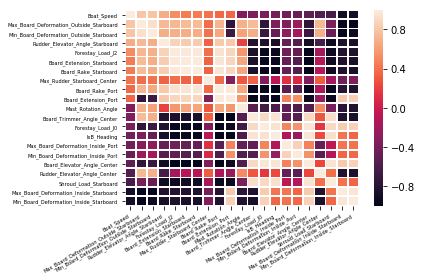

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

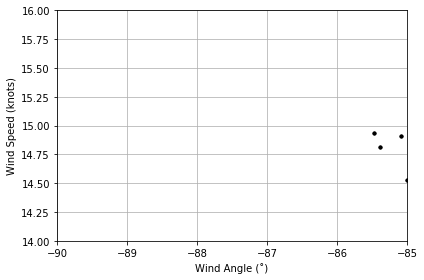

<Figure size 432x288 with 0 Axes>

In [13]:
# Retrieve another example of a bin. (-85 to -80˚, 12 to 14 knots)
bin_name = 'bin_x-90to-85_y14to16'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

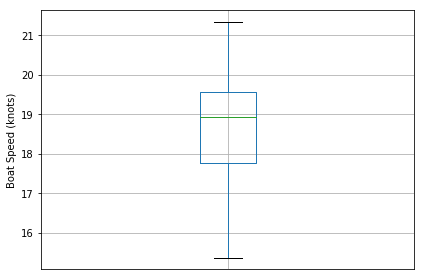

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

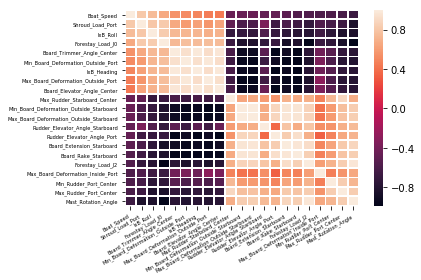

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

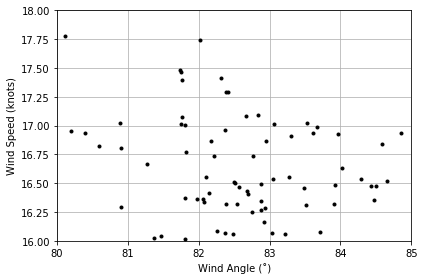

<Figure size 432x288 with 0 Axes>

In [14]:
# Retrieve another example of a bin. (80 to 85˚, 16 to 18 knots)
bin_name = 'bin_x80to85_y16to18'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

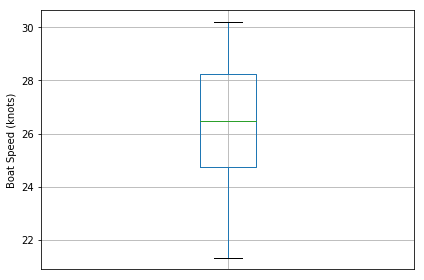

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

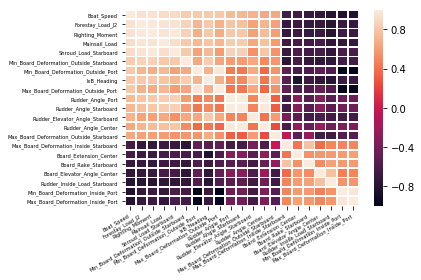

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

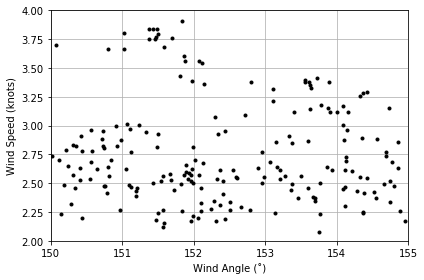

<Figure size 432x288 with 0 Axes>

In [17]:
# Retrieve another example of a bin. (150 to 155˚, 2 to 4 knots)
bin_name = 'bin_x150to155_y2to4'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

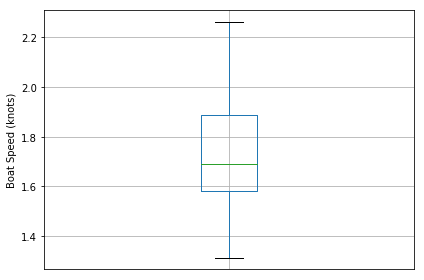

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

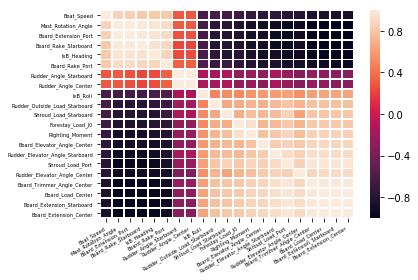

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)